In [13]:
import sys
sys.path.append('/home/kai/DAST/network')
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import torch.utils.data.dataloader as Data
import os
import time
from torch.autograd import Variable
from DAST_utils import *
from DAST_Network import *
from torch.utils.data import TensorDataset,DataLoader
import sys
from tqdm import tqdm
import math
import os
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [14]:
from typing import List

class DASTModel():
    def __init__(self, train_dataset_num, train_datasets: List[str], test_dataset: str, data_path: str, hyper_parameters: dict) -> None:
        self.TRAIN_DATASET_NUM = train_dataset_num
        self.TRAIN_DATASETS = train_datasets
        self.TEST_DATASET = test_dataset
        self.DATA_PATH = data_path
        self.X_train_1 = None
        self.Y_train_1 = None
        self.X_train_2 = None
        self.Y_train_2 = None
        self.X_train_3 = None
        self.Y_train_3 = None
        self.X_test = None
        self.Y_test = None
        self.X_train = None
        self.Y_train = None
        self.HP = hyper_parameters
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.best_predict = []
        self.last_predict_y = None
        self.train_loss_list = []
        self.test_loss_list = []
        self.best_mse_loss = 10000.0
        
    @staticmethod
    def RMSE(target, pred):
        square_error = (target - pred) ** 2
        mse =  (torch.sum(square_error)) / len(target)
        rmse = mse ** 0.5
        return rmse
    
    @staticmethod
    def MAE(target, pred):
        absolute_error = np.abs(target - pred)
        return torch.sum(absolute_error) / len(target)
    
    def _load_x_y(self, folder: str):
        y_tmp = np.load(f'{self.DATA_PATH}/{folder}/{folder}_train_Y.npy')
        return np.load(f'{self.DATA_PATH}/{folder}/{folder}_train_X.npy'), np.reshape(y_tmp, ((len(y_tmp), -1)))
    
    def _concate(self):
        self.X_train = np.concatenate((self.X_train_1, self.X_train_2, self.X_train_3), axis=0)
        self.Y_train = np.concatenate((self.Y_train_1, self.Y_train_2, self.Y_train_3), axis=0)

    def _load_np(self, ):
        for folder in self.TRAIN_DATASETS:
            dataset_num = folder[-1]
            if dataset_num == '1':
                self.X_train_1, self.Y_train_1 = self._load_x_y(folder)
            elif dataset_num == '2':
                self.X_train_2, self.Y_train_2 = self._load_x_y(folder)
            elif dataset_num == '4':
                self.X_train_3, self.Y_train_3 = self._load_x_y(folder)
        self.X_test = np.load(f'{self.DATA_PATH}/{self.TEST_DATASET}/{self.TEST_DATASET}_test_X.npy')
        self.Y_test = np.load(f'{self.DATA_PATH}/{self.TEST_DATASET}/{self.TEST_DATASET}_test_Y.npy')
        self.Y_test = np.reshape(self.Y_test, (len(self.Y_test), -1))
        self._concate()
            
    def _tensorizing(self):
        self.X_train = Variable(torch.Tensor(self.X_train).float())
        self.Y_train = Variable(torch.Tensor(self.Y_train).float())
        self.X_test = Variable(torch.Tensor(self.X_test).float())
        self.Y_test = Variable(torch.Tensor(self.Y_test).float())
        
    def _get_dataloader(self):
        train_dataset = TensorDataset(self.X_train, self.Y_train)
        train_loader = Data.DataLoader(dataset=train_dataset, batch_size=self.HP['batch_size'], shuffle=False)
        test_dataset = TensorDataset(self.X_test, self.Y_test)
        test_loader = Data.DataLoader(dataset=test_dataset, batch_size=self.HP['batch_size'], shuffle=False)
        return train_loader, test_loader
    
    def _get_model(self):
        debug = False
        model = DAST(self.HP['dim_val_s'], self.HP['dim_attn_s'], self.HP['dim_val_t'], self.HP['dim_attn_t'], self.HP['dim_val'], self.HP['dim_attn'], self.HP['time_step'], self.HP['input_size'], self.HP['dec_seq_len'], self.HP['output_sequence_length'], self.HP['n_decoder_layers'], self.HP['n_encoder_layers'], self.HP['n_heads'], debug)
        model = model.to(self.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=self.HP['lr'])
        criterion = nn.MSELoss()
        return model, optimizer, criterion
    
    def train(self, model, optimizer: torch.optim.Optimizer, criterion, train_loader: Data.DataLoader, epoch: int):
        model.train()
        tmp_loss_list = []
        loop = tqdm(train_loader, leave=True)
        for _, (X, Y) in enumerate(loop):
            batch_X = X.to(self.device)
            batch_Y = Y.to(self.device)
            out = model(batch_X)
            loss = criterion(out, batch_Y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tmp_loss_list.append(loss.item())
        loss_eopch = np.mean(np.array(tmp_loss_list))
        self.train_loss_list.append(loss_eopch)
        print('epoch = ',epoch,
                'train_loss = ',loss_eopch.item())

    def eval(self, model, test_loader: Data.DataLoader, criterion, epoch: int):
        model.eval()
        prediction_list = []
        with torch.no_grad():
            for _ ,(batch_x, _) in enumerate(test_loader):
                batch_X = batch_x.to(self.device)
                prediction = model(batch_X)
                prediction_list.append(prediction)

        out_batch_pre = torch.cat(prediction_list).detach().cpu()
        rmse_loss = self.RMSE(self.Y_test, out_batch_pre, )
        mae_loss = self.MAE(self.Y_test, out_batch_pre, )
        test_loss = criterion(out_batch_pre, self.Y_test)
        self.test_loss_list.append(test_loss)
        if (test_loss.item() < self.best_mse_loss):
            self.best_mse_loss = test_loss.item()
            self.best_predict = np.reshape(out_batch_pre, (-1)).tolist()
        print('rmse_loss = ', rmse_loss.item(),
                'mae_loss = ', mae_loss.item(),
                'mse_loss = ', test_loss.item())
        if epoch == self.HP['epochs'] - 1:
            self.last_predict_y = out_batch_pre
    
    def main(self):
        self._load_np()
        self._tensorizing()
        model, optimizer, criterion = self._get_model()
        train_loader, test_loader = self._get_dataloader()
        for epoch in range(self.HP['epochs']):
            self.train(model, optimizer, criterion, train_loader, epoch)
            self.eval(model, test_loader, criterion, epoch)


In [15]:
DATA_PATH = '../../../data/10FEMTO/processed_data/'
FOLDER = 'Bearing1_1'
TRAIN_DATASETS = ['Bearing1_1', 'Bearing1_2', 'Bearing1_4']
TEST_DATASET = 'Bearing1_3'

In [16]:
FEATURE = 16
EMBEDD = 20
HYPER_PARAMETERS = {
    'batch_size': 256,
    'dim_val': FEATURE,
    'dim_attn': EMBEDD,
    'dim_val_t': FEATURE,
    'dim_attn_t': EMBEDD,
    'dim_val_s': FEATURE,
    'dim_attn_s': EMBEDD,
    'n_heads': 4,
    'n_decoder_layers': 1,
    'n_encoder_layers': 2,
    'lr': 1e-3,
    'epochs': 3,
    'time_step': 40,
    'dec_seq_len': 4,
    'output_sequence_length': 1,
    'input_size': FEATURE,
}

In [17]:
dast_model = DASTModel(train_dataset_num=3, train_datasets=TRAIN_DATASETS, test_dataset=TEST_DATASET, data_path=DATA_PATH, hyper_parameters=HYPER_PARAMETERS)

In [18]:
dast_model.main()

100%|██████████| 20/20 [00:00<00:00, 23.34it/s]


epoch =  0 train_loss =  0.2749629025674949
rmse_loss =  0.22931355237960815 mae_loss =  0.18842865526676178 mse_loss =  0.052584707736968994


100%|██████████| 20/20 [00:00<00:00, 22.12it/s]


epoch =  1 train_loss =  0.04914252627640962
rmse_loss =  0.2217562049627304 mae_loss =  0.12273547798395157 mse_loss =  0.04917581379413605


100%|██████████| 20/20 [00:00<00:00, 21.54it/s]

epoch =  2 train_loss =  0.03477752931357827
rmse_loss =  0.19501368701457977 mae_loss =  0.13987769186496735 mse_loss =  0.038030337542295456


In [19]:
y = dast_model.Y_test.detach().cpu().numpy()
y = np.reshape(y, -1)
y = y.tolist()

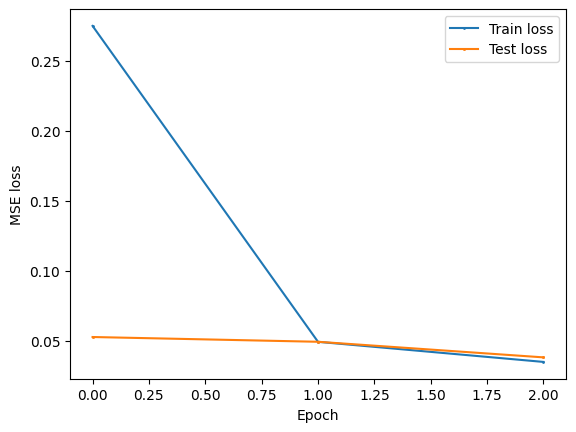

In [23]:
def loss_list():
    plt.plot(dast_model.train_loss_list, label='Train loss', marker='o', markersize=1)
    plt.plot(dast_model.test_loss_list, label='Test loss', marker='s', markersize=1)
    plt.xlabel('Epoch')
    plt.ylabel('MSE loss')
    plt.legend()
    plt.show()
loss_list()

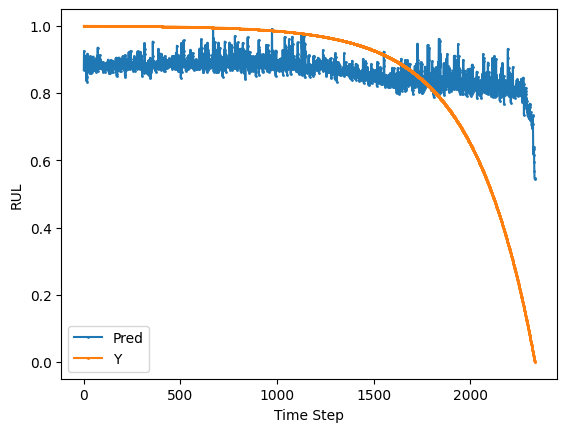

In [24]:
def best_predict():
    plt.plot(dast_model.best_predict, label='Pred', marker='o', markersize=1)
    plt.plot(y, label='Y', marker='s', markersize=1)
    plt.xlabel('Time Step')
    plt.ylabel('RUL')
    plt.legend()
    plt.show()
best_predict()

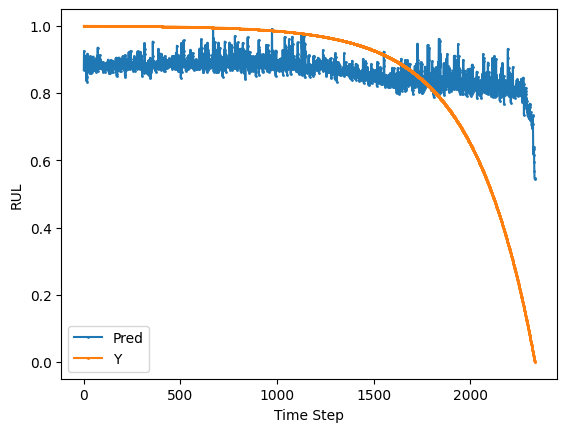

In [25]:
def last_predict_vs_y():
    last_predict_y = np.reshape(dast_model.last_predict_y, (-1))
    last_predict_y = last_predict_y.tolist()
    plt.plot(last_predict_y, label='Pred', marker='o', markersize=1)
    plt.plot(y, label='Y', marker='s', markersize=1)
    plt.xlabel('Time Step')
    plt.ylabel('RUL')
    plt.legend()
    plt.show()
last_predict_vs_y()

In [ ]:
# run above

# RUN above

In [ ]:
import matplotlib.pyplot as plt
# Example data
X_draw = X_train[:2763, 0, 4]
# Plotting the line chart
plt.plot(X_draw, label='Pred', marker='o', markersize=1)
# plt.plot(Y_test, label='Y', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Bearing 1-1 Horizontal Vibration Signal')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
plt.plot(X_train[0], label='Pred', marker='o', markersize=1)
plt.plot(Y_test, label='Y', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Train Loss Curve')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

for i in range(20):
    plt.plot(X_train_1[:, 0, i], marker='o', markersize=1)
    plt.ylim(min(X_train_1[:, 0, i]), max(X_train_1[:, 0, i]))
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label', )
    plt.title(f'Bearing1-1 Feature {i+1}')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

for i in range(20):
# Plotting the line chart
    plt.plot(X_train_2[:, 0, i], marker='o', markersize=1)
    plt.ylim(min(X_train_2[:, 0, i]), max(X_train_2[:, 0, i]))
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label', )
    plt.title(f'Bearing1-2 Feature {i+1}')
    # Display the plot
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

for i in range(20):
# Plotting the line chart
    plt.plot(X_train_3[:, 0, i], marker='o', markersize=1)
    plt.ylim(min(X_train_3[:, 0, i]), max(X_train_3[:, 0, i]))
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label', )
    plt.title(f'Bearing1-4 Feature {i+1}')
    # Display the plot
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

for i in range(20):
# Plotting the line chart
    plt.plot(X_test[:, 0, i], marker='o', markersize=1)
    plt.ylim(min(X_test[:, 0, i]), max(X_test[:, 0, i]))
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label', )
    plt.title(f'Bearing1-3 Feature {i+1}')
    # Display the plot
    plt.show()